# Spatial data operations {#spatial-operations}

## Prerequisites

In [35]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 6)
pd.options.display.max_rows = 10
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

Packages...

In [36]:
import geopandas as gpd
import numpy as np
import os
import rasterio
import scipy.ndimage

from rasterio.plot import show

Let us load the sample data for this chapter:

In [37]:
#| echo: false
from pathlib import Path
data_path = Path("data")
file_path = Path("data/landsat.tif")
if not file_path.exists():
  if not data_path.is_dir():
     os.mkdir(data_path)
  print("Attempting to get the data")
  import requests
  r = requests.get("https://github.com/geocompr/py/releases/download/0.1/landsat.tif")  
  with open(file_path, "wb") as f:
    f.write(r.content)

In [38]:
nz = gpd.read_file("data/nz.gpkg")
nz_height = gpd.read_file("data/nz_height.gpkg")
world = gpd.read_file('data/world.gpkg')
src_elev = rasterio.open("data/elev.tif")
src_multi_rast = rasterio.open("data/landsat.tif")
src_grain = rasterio.open('data/grain.tif')

## Introduction

## Spatial operations on vector data {#spatial-vec}

### Spatial subsetting

Spatial subsetting is the process of taking a spatial object and returning a new object containing only features that relate in space to another object. Analogous to attribute subsetting (covered in @sec-vector-attribute-subsetting), subsets of `GeoDataFrame`s can be created with square bracket (`[`) operator using the syntax `x[y]`, where `x` is an `GeoDataFrame` from which a subset of rows/features will be returned, and `y` is the 'subsetting object'. `y`, in turn, can be created using one of the binary geometry relation methods, such as `.intersects` (see @sec-topological-relations). 

To demonstrate spatial subsetting, we will use the `nz` and `nz_height` layers, which contain geographic data on the 16 main regions and 101 highest points in New Zealand, respectively (@fig-spatial-subset), in a projected coordinate system. The following code chunk creates an object representing Canterbury, then uses spatial subsetting to return all high points in the region:

In [39]:
canterbury = nz[nz["Name"] == "Canterbury"]
sel = nz_height.intersects(canterbury['geometry'].iloc[0])
canterbury_height = nz_height[sel]

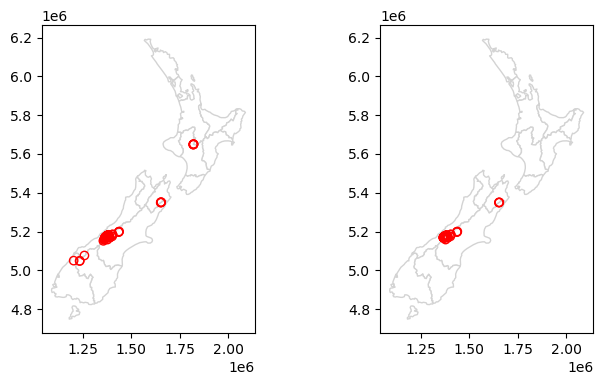

In [40]:
#| label: fig-spatial-subset
#| fig-cap: Spatial subsetting of points by intersection with polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color="white", edgecolor="lightgrey", ax=axes[0])
nz_height.plot(ax=base, color="None", edgecolor="red")
base = nz.plot(color="white", edgecolor="lightgrey", ax=axes[1])
canterbury_height.plot(ax=base, color="None", edgecolor="red");

Spatial subsetting 2...

In [41]:
non_canterbury_height = nz_height.overlay(canterbury, how='difference')

Plot...

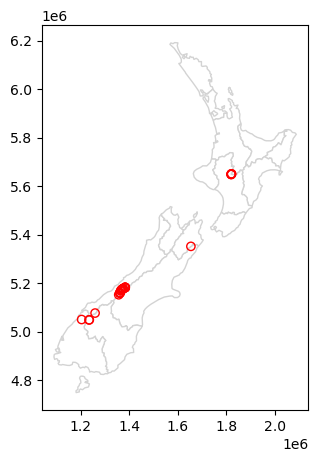

In [42]:
base = nz.plot(color="white", edgecolor="lightgrey")
non_canterbury_height.plot(ax=base, color="None", edgecolor="red");

...



### Topological relations {#sec-topological-relations}

...

<AxesSubplot:>

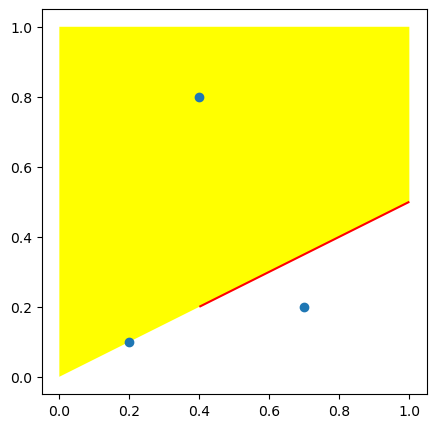

In [43]:
from shapely.geometry import Point, LineString, Polygon
points = gpd.GeoSeries([Point(0.2,0.1), Point(0.7,0.2), Point(0.4,0.8)])
line = LineString([(0.4,0.2), (1,0.5)])
poly = Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)])

p = gpd.GeoSeries(poly).plot(color='yellow')
p = gpd.GeoSeries(line).plot(ax=p, color='red')
points.plot(ax=p)

In [44]:
points.intersects(poly)

0     True
1    False
2     True
dtype: bool

In [45]:
points.within(poly)

0    False
1    False
2     True
dtype: bool

In [46]:
points.touches(poly)

0     True
1    False
2    False
dtype: bool

In [47]:
points.disjoint(poly)

0    False
1     True
2    False
dtype: bool

In [48]:
points.distance(poly) < 0.2

0    True
1    True
2    True
dtype: bool

### DE-9IM strings

...



### Spatial joining

Joining two non-spatial datasets relies on a shared 'key' variable, as described in @sec-vector-attribute-joining. Spatial data joining applies the same concept, but instead relies on spatial relations, described in the previous section. As with attribute data, joining adds new columns to the target object (the argument x in joining functions), from a source object (y).

The process is illustrated by the following example: imagine you have ten points randomly distributed across the Earth's surface and you ask, for the points that are on land, which countries are they in? Implementing this idea in a reproducible example will build your geographic data handling skills and show how spatial joins work. The starting point is to create points that are randomly scattered over the Earth's surface:

In [49]:
np.random.seed(11)  ## set seed for reproducibility
bb = world.total_bounds  ## the world's bounds
x = np.random.uniform(low=bb[0], high=bb[2], size=10)
y = np.random.uniform(low=bb[1], high=bb[3], size=10)
random_points = gpd.points_from_xy(x, y, crs=4326)
random_points = gpd.GeoSeries(random_points)
random_points = gpd.GeoDataFrame({'geometry': random_points})
random_points

,geometry
0,POINT (-115.10291 36.78178)
1,POINT (-172.98891 -71.02938)
2,POINT (-13.24134 65.23272)
3,POINT (80.97621 58.85495)
4,POINT (-28.72671 -61.25002)
5,POINT (-5.24625 19.83849)
6,POINT (-175.39891 -86.34517)
7,POINT (-4.54623 -69.64082)
8,POINT (159.05039 -34.99599)
9,POINT (126.28622 -62.49509)


The scenario illustrated in @fig-spatial-join shows that the `random_points` object (top left) lacks attribute data, while the world (top right) has attributes, including country names shown for a sample of countries in the legend. Spatial joins are implemented with `gpd.sjoin`, as illustrated in the code chunk below. The output is the `random_joined` object which is illustrated in @fig-spatial-join (bottom left). Before creating the joined dataset, we use spatial subsetting to create world_random, which contains only countries that contain random points, to verify the number of country names returned in the joined dataset should be four (see the top right panel of @fig-spatial-join).

In [50]:
# Subset
world_random = world[world.intersects(random_points.unary_union)]
world_random

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
4,US,United States,North America,...,78.841463,51921.984639,MULTIPOLYGON (((-171.73166 63.7...
18,RU,Russian Federation,Europe,...,70.743659,25284.586202,MULTIPOLYGON (((-180.00000 64.9...
52,ML,Mali,Africa,...,57.007000,1865.160622,MULTIPOLYGON (((-11.51394 12.44...
159,AQ,Antarctica,Antarctica,...,NaN,NaN,MULTIPOLYGON (((-180.00000 -89....


In [51]:
# Spatial join
random_joined = gpd.sjoin(random_points, world, how='left')
random_joined

,geometry,index_right,iso_a2,...,pop,lifeExp,gdpPercap
0,POINT (-115.10291 36.78178),4.0,US,...,318622525.0,78.841463,51921.984639
1,POINT (-172.98891 -71.02938),NaN,NaN,...,NaN,NaN,NaN
2,POINT (-13.24134 65.23272),NaN,NaN,...,NaN,NaN,NaN
3,POINT (80.97621 58.85495),18.0,RU,...,143819666.0,70.743659,25284.586202
4,POINT (-28.72671 -61.25002),NaN,NaN,...,NaN,NaN,NaN
5,POINT (-5.24625 19.83849),52.0,ML,...,16962846.0,57.007000,1865.160622
6,POINT (-175.39891 -86.34517),159.0,AQ,...,NaN,NaN,NaN
7,POINT (-4.54623 -69.64082),NaN,NaN,...,NaN,NaN,NaN
8,POINT (159.05039 -34.99599),NaN,NaN,...,NaN,NaN,NaN
9,POINT (126.28622 -62.49509),NaN,NaN,...,NaN,NaN,NaN


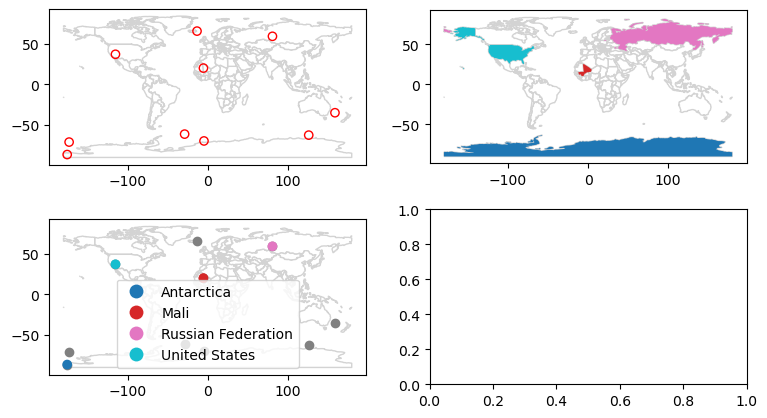

In [52]:
#| label: fig-spatial-join
#| fig-cap: Illustration of a spatial join. A new attribute variable is added to random points (top left) from source world object (top right) resulting in the data represented in the final panel.

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
base = world.plot(color="white", edgecolor="lightgrey", ax=axes[0][0])
random_points.plot(ax=base, color="None", edgecolor="red")
base = world.plot(color="white", edgecolor="lightgrey", ax=axes[0][1])
world_random.plot(ax=base, column='name_long')
base = world.plot(color="white", edgecolor="lightgrey", ax=axes[1][0])
random_joined.geometry.plot(ax=base, color='grey');
random_joined.plot(ax=base, column='name_long', legend=True);

### Non-overlapping joins

...

### Spatial aggregation

As with attribute data aggregation, spatial data aggregation condenses data: aggregated outputs have fewer rows than non-aggregated inputs. Statistical aggregating functions, such as mean, average, or sum, summarise multiple values of a variable, and return a single value per grouping variable. Section ... demonstrated how the `.groupby` method, combined with summary functions such as `.sum`, condense data based on attribute variables. This section shows how grouping by spatial objects can be acheived using spatial joins combined with non-spatial aggregation.


Returning to the example of New Zealand, imagine you want to find out the average height of high points in each region: it is the geometry of the source (`nz`, in this case) that defines how values in the target object (`nz_height`) are grouped. This can be done in two steps. First, we "attach" the region classification of each point, using spatial join. Note that just one distinct attribute (such as `Name` in this case) is sufficient for our purposes:

In [53]:
gpd.sjoin(nz_height, nz[['Name', 'geometry']], how='left')

,t50_fid,elevation,geometry,index_right,Name
0,2353944,2723,POINT (1204142.603 5049971.287),12,Southland
1,2354404,2820,POINT (1234725.325 5048309.302),11,Otago
2,2354405,2830,POINT (1235914.511 5048745.117),11,Otago
3,2369113,3033,POINT (1259701.635 5076570.049),9,West Coast
4,2362630,2749,POINT (1378169.600 5158491.453),10,Canterbury
...,...,...,...,...,...
96,2408394,2797,POINT (1821014.190 5647970.666),7,Manawatu-Wanganui
97,2408395,2757,POINT (1820642.909 5648331.194),7,Manawatu-Wanganui
98,2408397,2751,POINT (1820659.873 5649488.235),2,Waikato
99,2408406,2720,POINT (1822262.592 5650428.656),2,Waikato


Second, ...



### Joining incongruent layers

...



### Distance relations

While topological relations are binary — a feature either intersects with another or does not — distance relations are continuous. The distance between two objects is calculated with the `distance` method. The method is applied on a `GeoSeries` (or a `GeoDataFrame`), with the argument being an individual `shapely` geometry. The result is a `Series` of pairwise distances.

This is illustrated in the code chunk below, which finds the distance between the three highest point in New Zealand:

In [54]:
nz_heighest = nz_height.sort_values(by='elevation', ascending=False).iloc[:3, :]
nz_heighest

,t50_fid,elevation,geometry
64,2372236,3724,POINT (1369317.630 5169132.284)
63,2372235,3717,POINT (1369512.866 5168235.616)
67,2372252,3688,POINT (1369381.942 5168761.875)


and the geographic centroid of the Canterbury region, created in Section 4.2.1: 

In [55]:
canterbury_centroid = canterbury.centroid.iloc[0]

Here are the distances:

In [56]:
nz_heighest.distance(canterbury_centroid)

64    115539.995747
63    115390.248038
67    115493.594066
dtype: float64

To obtain a distance matrix, i.e., a pairwise set of distances between all combinations of features in objects `x` and `y`, we need to use the `.apply` method. This is illustrated in the command below, which finds the distances between the first three features in `nz_height` and the Otago and Canterbury regions of New Zealand represented by the object `co`:

In [57]:
sel = nz['Name'].str.contains('Canter|Otag')
co = nz[sel]
co

,Name,Island,Land_area,...,Median_income,Sex_ratio,geometry
10,Canterbury,South,44504.499091,...,30100,0.975327,MULTIPOLYGON (((1686901.914 535...
11,Otago,South,31186.309188,...,26300,0.951169,MULTIPOLYGON (((1335204.789 512...


The distance matrix `d` is obtained as follows (technically speaking, this is a `DataFrame`). In plain language, we take the geometry from each each row in `nz_height.iloc[:3, :]`, and apply the `.distance` method on `co` with that row as the argument:

In [58]:
d = nz_height.iloc[:3, :].apply(lambda x: co.distance(x['geometry']), axis=1)
d

,10,11
0,123537.158269,15497.717252
1,94282.773074,0.000000
2,93018.560814,0.000000


Note that the distance between the second and third features in `nz_height` and the second feature in `co` is zero. This demonstrates the fact that distances between points and polygons refer to the distance to any part of the polygon: The second and third points in `nz_height` are in Otago, which can be verified by plotting them:

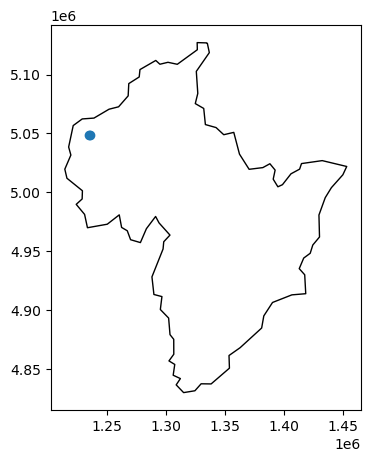

In [59]:
base = co.iloc[[1]].plot(color='none')
nz_height.iloc[1:3, :].plot(ax=base);

## Spatial operations on raster data {#spatial-ras}

### Spatial subsetting

The previous chapter (Section @sec-manipulating-raster-objects) demonstrated how to retrieve values associated with specific cell IDs or row and column combinations. Raster objects can also be extracted by location (coordinates) and other spatial objects. To use coordinates for subsetting, we can use the `.sample` method of a `rasterio` file connection object, combined with a list of coordinate tuples. The methods is demonstrated below to find the value of the cell that covers a point located at coordinates of 0.1, 0.1 in `elev`. The returned object is a *generator*: 

In [60]:
src_elev.sample([(0.1, 0.1)])

<generator object sample_gen at 0x7fbc267ae260>

In case we want all values at once we can apply `list`. The result is `16`:

In [61]:
list(src_elev.sample([(0.1, 0.1)]))

[array([16], dtype=uint8)]

Raster objects can also be subset with another raster object, as demonstrated in the code chunk below:

...

In [62]:
# ...

Another common use case of spatial subsetting is using a boolean mask, based on another raster with the same extent and resolution, or the original one, as illustrated in Figure .... To do that, we "erase" the values in the array of one raster, according to another corresponding "mask" raster. For example, let us read the `elev.tif` raster array: 

In [63]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

and create a correspinding random mask:

In [64]:
np.random.seed(1)
mask = np.random.choice([True, False], elev.shape)
mask

array([[False, False,  True,  True, False, False],
       [False, False, False,  True,  True, False],
       [ True, False, False,  True,  True, False],
       [ True,  True,  True, False,  True,  True],
       [False,  True,  True,  True, False,  True],
       [ True,  True, False, False, False, False]])

In the code chunk above, we have created a mask object called `mask` with values randomly assigned to `True` and `False`. Next, we want to keep those values of `elev` which are `False` in `mask` (i.e., they are *not* masked). In other words, we want to mask `elev` with `mask`. The result is stored in a copy named `elev1`. To be able to store `np.nan` in the raster, we also need to convert it to float (see @sec-summarizing-raster-objects):

In [65]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[mask] = np.nan
elev1

array([[ 1.,  2., nan, nan,  5.,  6.],
       [ 7.,  8.,  9., nan, nan, 12.],
       [nan, 14., 15., nan, nan, 18.],
       [nan, nan, nan, 22., nan, nan],
       [25., nan, nan, nan, 29., nan],
       [nan, nan, 33., 34., 35., 36.]])

The result is shown in @fig-raster-subset.

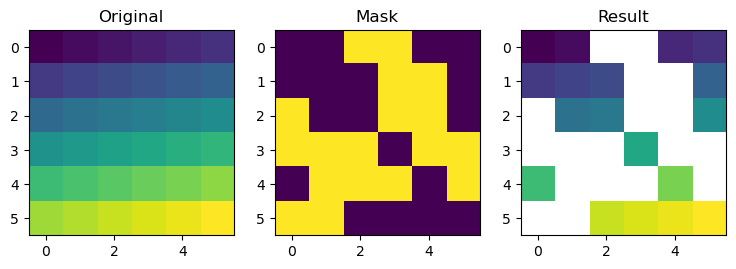

In [66]:
#| label: fig-raster-subset
#| fig-cap: Original raster (left). Raster mask (middle). Output of masking a raster (right).

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
show(elev, ax=axes[0])
show(mask, ax=axes[1])
show(elev1, ax=axes[2])
axes[0].set_title("Original")
axes[1].set_title("Mask")
axes[2].set_title("Result");

The above approach can be also used to replace some values (e.g., expected to be wrong) with `nan`:

In [67]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[elev1 < 20] = np.nan
elev1

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

These operations are in fact Boolean local operations, since we compare cell-wise two rasters. The next subsection explores these and related operations in more detail.

### Map algebra {#sec-map-algebra}

The term 'map algebra' was coined in the late 1970s to describe a "set of conventions, capabilities, and techniques" for the analysis of geographic raster and (although less prominently) vector data (Tomlin 1994). In this context, we define map algebra more narrowly, as operations that modify or summarise raster cell values, with reference to surrounding cells, zones, or statistical functions that apply to every cell.

Map algebra operations tend to be fast, because raster datasets only implicitly store coordinates, hence the old adage “raster is faster but vector is corrector”. The location of cells in raster datasets can be calculated by using its matrix position and the resolution and origin of the dataset (stored in the header). For the processing, however, the geographic position of a cell is barely relevant as long as we make sure that the cell position is still the same after the processing. Additionally, if two or more raster datasets share the same extent, projection and resolution, one could treat them as matrices for the processing.

This is the way that map algebra works with the terra package. First, the headers of the raster datasets are queried and (in cases where map algebra operations work on more than one dataset) checked to ensure the datasets are compatible. Second, map algebra retains the so-called one-to-one locational correspondence, meaning that cells cannot move. This differs from matrix algebra, in which values change position, for example when multiplying or dividing matrices.

Map algebra (or cartographic modeling with raster data) divides raster operations into four subclasses (Tomlin 1990), with each working on one or several grids simultaneously:

* Local or per-cell operations
* Focal or neighborhood operations. Most often the output cell value is the result of a 3 x 3 input cell block
* Zonal operations are similar to focal operations, but the surrounding pixel grid on which new values are computed can have irregular sizes and shapes
* Global or per-raster operations; that means the output cell derives its value potentially from one or several entire rasters

This typology classifies map algebra operations by the number of cells used for each pixel processing step and the type of the output. For the sake of completeness, we should mention that raster operations can also be classified by discipline such as terrain, hydrological analysis, or image classification. The following sections explain how each type of map algebra operations can be used, with reference to worked examples.

### Local operations {#sec-raster-local-operations}

Local operations comprise all cell-by-cell operations in one or several layers. 
Raster algebra is a classical use case of local operations - this includes adding or subtracting values from a raster, squaring and multipling rasters. 
Raster algebra also allows logical operations such as finding all raster cells that are greater than a specific value (5 in our example below). 
Local operations are applied using the `numpy` array operations syntax, as demonstrated below:

First, we need to read raster values:

In [68]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

Now, any element-wise array operation can be applied. For example:

In [69]:
elev + elev

array([[ 2,  4,  6,  8, 10, 12],
       [14, 16, 18, 20, 22, 24],
       [26, 28, 30, 32, 34, 36],
       [38, 40, 42, 44, 46, 48],
       [50, 52, 54, 56, 58, 60],
       [62, 64, 66, 68, 70, 72]], dtype=uint8)

@fig-raster-local-operations demonstrates a few more examples.

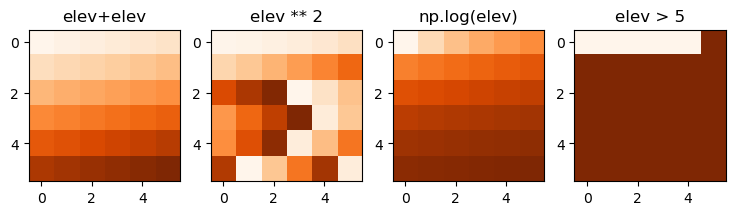

In [70]:
#| label: fig-raster-local-operations
#| fig-cap: 'Examples of different local operations of the elev raster object: adding two rasters, squaring, applying logarithmic transformation, and performing a logical operation.'

fig, axes = plt.subplots(ncols=4, figsize=(9,5))
show(elev + elev, ax=axes[0], cmap="Oranges")
show(elev ** 2, ax=axes[1], cmap="Oranges")
show(np.log(elev), ax=axes[2], cmap="Oranges")
show(elev > 5, ax=axes[3], cmap="Oranges")
axes[0].set_title("elev+elev")
axes[1].set_title("elev ** 2")
axes[2].set_title("np.log(elev)")
axes[3].set_title("elev > 5");

Another good example of local operations is the classification of intervals of numeric values into groups such as grouping a digital elevation model into low (class 1), middle (class 2) and high elevations (class 3). Here, we assign the raster values in the ranges 0–12, 12–24 and 24–36 are reclassified to take values 1, 2 and 3, respectively.

In [71]:
recl = elev.copy()
recl[(elev > 0)  & (elev <= 12)] = 1
recl[(elev > 12) & (elev <= 24)] = 2
recl[(elev > 24) & (elev <= 36)] = 3

The reclassified result is shown in @fig-raster-reclassify.

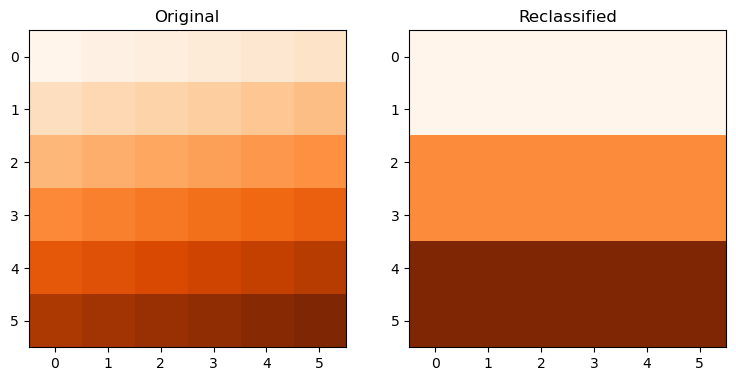

In [72]:
#| label: fig-raster-reclassify
#| fig-cap: Reclassifying a continuous raster into three categories.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(elev, ax=axes[0], cmap="Oranges")
show(recl, ax=axes[1], cmap="Oranges")
axes[0].set_title("Original")
axes[1].set_title("Reclassified");

The calculation of the normalized difference vegetation index (NDVI) is a well-known local (pixel-by-pixel) raster operation. It returns a raster with values between -1 and 1; positive values indicate the presence of living plants (mostly > 0.2). NDVI is calculated from red and near-infrared (NIR) bands of remotely sensed imagery, typically from satellite systems such as Landsat or Sentinel. Vegetation absorbs light heavily in the visible light spectrum, and especially in the red channel, while reflecting NIR light, explaining the NVDI formula:

$$NDVI=\frac{NIR-Red} {NIR+Red}$$

Let's calculate NDVI for the multispectral satellite file of the Zion National Park.

In [73]:
multi_rast = src_multi_rast.read()
nir = multi_rast[3,:,:]
red = multi_rast[2,:,:]
ndvi = (nir-red)/(nir+red)

Convert values >1 to "No Data":

In [74]:
ndvi[ndvi>1] = np.nan

When plotting an RGB image using the `show` function, the function assumes that:

* Values are in the range `[0,1]` for floats, or `[0,255]` for integers (otherwise clipped)
* The order of bands is RGB

To "prepare" the multi-band raster for `show`, we therefore reverse the order of bands (which is originally BGR+NIR), and divided by the maximum to set the maximum value at `1`:

In [75]:
multi_rast_rgb = multi_rast[(2,1,0), :, :] / multi_rast.max()

The result is shown in @fig-raster-ndvi.

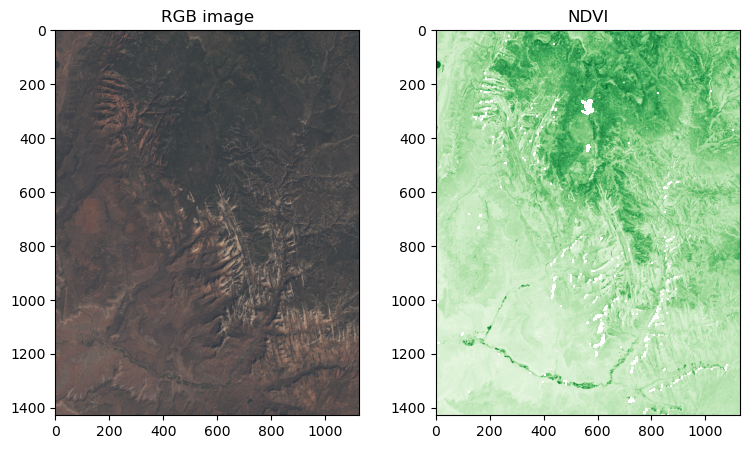

In [76]:
#| label: fig-raster-ndvi
#| fig-cap: RGB image (left) and NDVI values (right) calculated for the example satellite file of the Zion National Park.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(multi_rast_rgb, ax=axes[0], cmap="RdYlGn")
show(ndvi, ax=axes[1], cmap="Greens")
axes[0].set_title("RGB image")
axes[1].set_title("NDVI");

### Focal operations

While local functions operate on one cell, though possibly from multiple layers, focal operations take into account a central (focal) cell and its neighbors. 
The neighborhood (also named kernel, filter or moving window) under consideration is typically of size 3-by-3 cells (that is the central cell and its eight surrounding neighbors), but can take on any other (not necessarily rectangular) shape as defined by the user. 
A focal operation applies an aggregation function to all cells within the specified neighborhood, uses the corresponding output as the new value for the the central cell, and moves on to the next central cell (Figure ...). 
Other names for this operation are spatial filtering and convolution (Burrough, McDonnell, and Lloyd 2015).

In Python, the `scipy.ndimage` package has a comprehensive collection of [functions](https://docs.scipy.org/doc/scipy/reference/ndimage.html#filters) to perform filtering of `numpy` arrays, such as:

* `minimum_filter`
* `maximum_filter`
* `uniform_filter` (i.e., mean filter)
* `median_filter`
etc.

In this group of functions, we define the shape of the moving window with either one of:

* `size`—a single number or tuple, implying a filter of those dimensions
* `footprint`—a boolean array, representing both the window shape and the identity of elements being included

In addition to specific built-in filters, 

* `convolve` applies the sum function after multiplying by a custom `weights` array
* `generic_filter` makes it possible to pass any custom function, where the user can specify any type of custom window-based calculatio.

For example, here we apply the minimum filter with window size of `3` on `elev`: 

In [77]:
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

In [78]:
elev_min = scipy.ndimage.minimum_filter(elev, size=3)
elev_min

array([[ 1,  1,  2,  3,  4,  5],
       [ 1,  1,  2,  3,  4,  5],
       [ 7,  7,  8,  9, 10, 11],
       [13, 13, 14, 15, 16, 17],
       [19, 19, 20, 21, 22, 23],
       [25, 25, 26, 27, 28, 29]], dtype=uint8)

Special care should be given to the edge pixels. How should they be calculated? `scipy.ndimage` gives several options through the `mode` parameter:

* `reflect` (the default)
* `constant`
* `nearest`
* `mirror`
* `wrap`

Sometimes artificially extending raster edges is considered unsuitable. 
In other words, we may wish the resulting raster to contain pixel values with "complete" windows only, for example to have a uniform sample size or because values in all directions matter (such as in topographic calculations). 
There is no specific option *not* to extend edges in `scipy.ndimage`. 
However, to get the same effect, the edges of the filtered array can be assigned with `nan`, in a number of rows and columns according to filter size. 
For example, when using a filter of `size=3`, the first "layer" of pixels may be assigned with `nan`, reflecting the fact that these pixels have incomplete 3*3 neighborhoods:

In [80]:
elev_min = elev_min.astype('float')
elev_min[:, [0, -1]] = np.nan
elev_min[[0, -1], :] = np.nan
elev_min

array([[nan, nan, nan, nan, nan, nan],
       [nan,  1.,  2.,  3.,  4., nan],
       [nan,  7.,  8.,  9., 10., nan],
       [nan, 13., 14., 15., 16., nan],
       [nan, 19., 20., 21., 22., nan],
       [nan, nan, nan, nan, nan, nan]])

We can quickly check if the output meets our expectations. 
In our example, the minimum value has to be always the upper left corner of the moving window (remember we have created the input raster by row-wise incrementing the cell values by one starting at the upper left corner). 

Focal functions or filters play a dominant role in image processing. Low-pass or smoothing filters use the mean function to remove extremes. 
In the case of categorical data, we can replace the mean with the mode, which is the most common value. 
By contrast, high-pass filters accentuate features. The line detection Laplace and Sobel filters might serve as an example here. 

Terrain processing, the calculation of topographic characteristics such as slope, aspect and flow directions, relies on focal functions. 
The `TerrainAttribute` function from package `richdem` can be used to calculate common [metrics](https://richdem.readthedocs.io/en/latest/python_api.html?highlight=TerrainAttribute#richdem.TerrainAttribute), specified through the `attrib` argument, namely:

* `slope_riserun` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_percentage` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_degrees` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_radians` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `aspect` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `planform_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `profile_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107

### Zonal operations

Just like focal operations, zonal operations apply an aggregation function to multiple raster cells. 
However, a second raster, usually with categorical values, defines the zonal filters (or 'zones') in the case of zonal operations, as opposed to a predefined neighborhood window in the case of focal operation presented in the previous section. 
Consequently, raster cells defining the zonal filter do not necessarily have to be neighbors. 
Our grain size raster is a good example, as illustrated in the right panel of Figure 3.2: different grain sizes are spread irregularly throughout the raster. 
Finally, the result of a zonal operation is a summary table grouped by zone which is why this operation is also known as zonal statistics in the GIS world. This is in contrast to focal operations which return a raster object.

To demonstrate, let us get back to the `grain` and `elev` rasters (Figure 3.2). To calculate zonal statistics, we use the arrays with raster values. The `elev` array was already imported earlier:

In [82]:
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

The `grain` array is imported here using `.read`:

In [81]:
grain = src_grain.read(1)
grain

array([[1, 0, 1, 2, 2, 2],
       [0, 2, 0, 0, 2, 1],
       [0, 2, 2, 0, 0, 2],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1],
       [2, 1, 2, 2, 0, 2]], dtype=uint8)

Our interntion is to calculate the average (or any other summary function, for that matter) of *elevation* in each zone defined by *grain* values. First, we can obtain the unique values defining the zones using `np.unique`: 

In [83]:
np.unique(grain)

array([0, 1, 2], dtype=uint8)

Now, we can use [dictionary conprehension](https://stackoverflow.com/questions/14507591/python-dictionary-comprehension) to "split" the `elev` array into separate one-dimensional arrays with values per `grain` group, with keys being the unique `grain` values:

In [84]:
z = {i: elev[grain == i] for i in np.unique(grain)}
z

{0: array([ 2,  7,  9, 10, 13, 16, 17, 19, 20, 35], dtype=uint8),
 1: array([ 1,  3, 12, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32], dtype=uint8),
 2: array([ 4,  5,  6,  8, 11, 14, 15, 18, 28, 31, 33, 34, 36], dtype=uint8)}

At this stage, we can expand the dictionary comprehension expression to calculate the mean elevation associated with each grain size class. Instead of placing the elevation values (`elev[grain==i]`) into the dictionary values, we place their mean (`elev[grain==i].mean()`):

In [ ]:
z = {i: elev[grain == i].mean() for i in np.unique(grain)}
z

This returns the statistics for each category, here the mean elevation for each grain size class. For example, the mean elevation in pixels characterized by grain size `0` is `14.8`, and so on.

### Global operations and distances

...

### Map algebra counterparts in vector processing

...

### Merging rasters

...

## Exercises

* Write a function which accepts and array and an `int` specifying the number of rows/columns to erase along an array edges. The function needs to return the modified array with `nan` values along its edges.
